In [1]:
from gym.envs.toy_text import BlackjackEnv
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np


In [2]:
def plot_state(env):
    env_screen = env.render()
    fig = plt.figure(figsize=(10, 10), dpi=40)
    ax = fig.add_subplot() 
    ax.imshow(env_screen, interpolation=None)
    plt.axis("off")
    plt.grid(visible=None)
    plt.show()

## 1 Блэкджек и стратегии
### 1.1 Очень простая стратегия

In [3]:
env = gym.make('Blackjack-v1', render_mode="rgb_array")

N_EPISODES = int(1e5)

def simple_strategy(state):
    if state[0] in [19, 20, 21]:
        return 0
    else:
        return 1

    
mean_reward = 0    
for _ in tqdm(range(N_EPISODES)):
    state, _ = env.reset()
    done = False
    while not done:
        state, reward, done, desc, _  = env.step(simple_strategy(state))
        mean_reward += int(reward)
    
mean_reward = float(mean_reward) / N_EPISODES

print(f"Средний выигрыш для данной стратегии: {mean_reward}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Средний выигрыш для данной стратегии: -0.20114


In [4]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

"Обуть" казино с такой стратегией не получится

### 1.2 Обучение с подкреплением без модели

Реализовал On-Policy Monte Carlo Control для $\epsilon-soft$ policy. Реализация - в виде класса "спецагента"
Посчитан средний выигрыш по 1e6 итерациям агентов обученных на разных количествах эпизодов. Сделан перебор гиперпараметров: в нашем случае $\epsilon$ и $\gamma$. Результаты см. на графиках ниже

In [80]:
class MCControlAgent:
    def __init__(self, eps=0.01, n_space=(32, 11, 2), n_action=2, random_state=300, gamma=1.0):
        
        self.n_space = n_space
        self.n_action = n_action
        self.gamma = gamma
        self.eps = eps
        
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.policy = np.random.randint(0, self.n_action, size=self.n_space, dtype=int)
        
        self.Q = np.zeros(n_space + (n_action,))
        self.N = np.zeros(n_space + (n_action,))
        self.R = np.zeros(n_space + (n_action,))
        
        
        
    def exploration_action(self, state):
        
        if np.random.uniform() <= self.eps:
            action = np.random.randint(0, self.n_action)
        else:
            action = self.policy[state]
            
        return action
    
    def inference_action(self, state):
        
        return self.policy[state]
    
    def learn(self, env, n_episodes=100, verbose=True):
        
        for ii in tqdm(range(n_episodes), disable=not verbose):
            state, _ = env.reset()
            state = tuple(map(int, state))
            done = False
            episode = []
            #print(f"episode starts: {state}")
            while not done:
                action = self.exploration_action(state)
                new_state, reward, done, desc, _  = env.step(action)
                episode.append((state + (action,), reward))
                state = tuple(map(int, new_state))
                
            # Every visit MC, эквивалентен First visit MC 
            # Т. к. в данной постановке мы не должы вернуться в то же состояние после взятия карты
            t_max = len(episode)
            g = 0
            for (state_action, reward) in episode[-1::-1]:
                self.N[state_action] += 1
                g = self.gamma * g + reward
                self.R[state_action] += g
                
            self.Q[self.N > 0] = self.R[self.N > 0] / self.N[self.N > 0]
            self.policy = np.argmax(self.Q, axis=-1)


    def evaluate_agent(self, env, n_avg=100, verbose=True):
        
        np.random.seed(self.random_state + 1)
        
        total_reward = 0
        for ii in tqdm(range(n_avg), disable=not verbose):
            state, _ = env.reset()
            state = tuple(map(int, state))
            done = False
            while not done:
                action = self.inference_action(state)
                new_state, reward, done, desc, _  = env.step(action)
                state = tuple(map(int, new_state))
            total_reward += reward
            
        return total_reward / n_avg
    
    
def get_score(agent, env, n_episodes=100, n_avg=int(100000), verbose=True):

    agent.learn(env, n_episodes=n_episodes, verbose=verbose)
    return agent.evaluate_agent(env, n_avg=n_avg, verbose=verbose)


def get_score_train_plot(agent_class,
                         env,
                         all_n_episodes=np.array([1, 10, 100, 1000, 10000, 100000], dtype=int),
                         n_avg=int(1e5),
                         eps=0.01,
                         gamma=1.0,
                         n_action=2,
                         n_space=(32, 11, 2)):
    
    
    mean_rewards = np.zeros(all_n_episodes.shape)

    for ii in tqdm(range(all_n_episodes.size)):
        agent = agent_class(gamma=gamma, eps=eps, n_action=n_action, n_space=n_space)
        mean_rewards[ii] = get_score(agent, env, n_episodes=all_n_episodes[ii], n_avg=n_avg, verbose=False)
    
    return(mean_rewards)

In [13]:
agent = MCControlAgent(eps=0.1)

agent.learn(env, n_episodes=1000_000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
agent.evaluate_agent(env, n_avg=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.04536

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

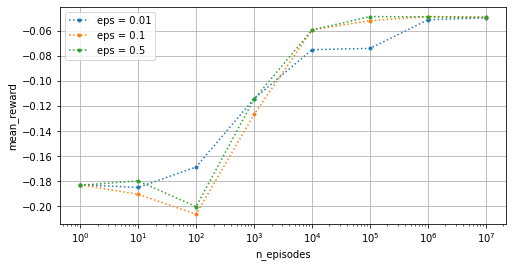

In [8]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.xlabel("n_episodes")
plt.ylabel("mean_reward")
plt.xscale("log")
for eps in [0.01, 0.1, 0.5]:
    all_n_episodes = np.array([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000], dtype=int)
    mean_rewards = get_score_train_plot(MCControlAgent, env, all_n_episodes=all_n_episodes, n_avg=int(1e6), eps=eps)
    plt.plot(all_n_episodes, mean_rewards, ".:", label = f"eps = {eps}")
    
plt.legend()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

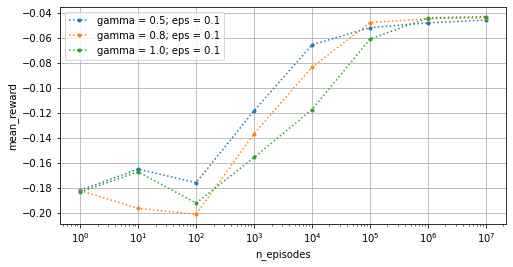

In [22]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.xlabel("n_episodes")
plt.ylabel("mean_reward")
plt.xscale("log")
for gamma in [0.5, 0.8, 1.0]:
    all_n_episodes = np.array([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000], dtype=int)
    mean_rewards = get_score_train_plot(MCControlAgent, env, all_n_episodes=all_n_episodes, n_avg=int(1e6), eps=0.1, gamma=gamma)
    plt.plot(all_n_episodes, mean_rewards, ".:",  label = f"gamma = {gamma}; eps = 0.1")
    
plt.legend()

К сожалению, в данной постановке обыграть казино не получится. Из плюсов, алгоритм работает, проигрываем, в среднем, меньше. 
- Для этой модели влияние гиперпараметров $\epsilon$ и $\gamma$ не оказывает значительного результата ($\gamma$ - понятно, а вот с $\epsilon$ неочевидно, почему так получается). Важно заметить, что в данной реализации оценка средней награды агента проходит на другом наборе эпизодов чем при обучении. Следовательно, средняя награда может уменьшаться при обучении. Гипертрофированный пример: одинаковые эпизоды, которые агент ещ не видел при обучении и дающие нулевую награду так как случайная начальная политика предлагала брать карту когда не надо) 

Переходим к п. 2 с измененной постановкой

## 2 Удвоение

Будем использовать тот же алгоритм что и в п. 1. Меняем пространство S, A и окружение. Последнее получим расширив Blackjack-v1 из gym. Внизу копипаста из гитхаба по ссылке, приведенной в условии домашнего задания. Добавил action = 2 (Double)

Извиняюсь за копипасту, но так проще (в том числе, проверить реализацию)

In [46]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvDouble(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    ### Description
    Card Values:
    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.
    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), hit (1), and double (2).
    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if <a href="#nat">natural</a> is True)
        +1 (if <a href="#nat">natural</a> is False)
    ### Arguments
    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```
    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).
    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3, start=0)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # Double
            self.player.append(draw_card(self.np_random))
            terminated = True
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                    reward = 2.0
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


# Pixel art from Mariia Khmelnytska (https://www.123rf.com/photo_104453049_stock-vector-pixel-art-playing-cards-standart-deck-vector-set.html)

In [50]:
env = BlackjackEnvDouble()
agent = MCControlAgent(eps=0.1, n_action=3)
agent.learn(env, n_episodes=int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

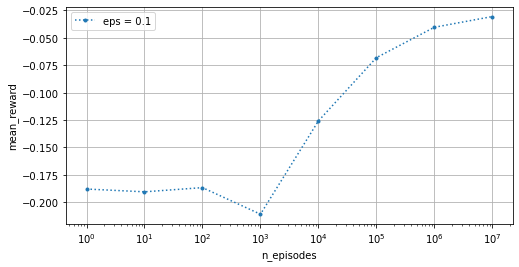

In [84]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.xlabel("n_episodes")
plt.ylabel("mean_reward")
plt.xscale("log")
env = BlackjackEnvDouble()
for eps in [0.1]:
    all_n_episodes = np.array([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000], dtype=int)
    mean_rewards = get_score_train_plot(MCControlAgent, env, all_n_episodes=all_n_episodes, n_avg=int(1e6), eps=eps, n_action=3)
    plt.plot(all_n_episodes, mean_rewards, ".:", label = f"eps = {eps}")
    
plt.legend()

Результат лучше чем в п 1 (-0.027 против -0.043).  Вдобавок агент продолжает учиться (нет насыщения), следовательно, его можно дообучить на еще более хороший результат. 

Пока что мы продолжаем проигрывать казино.

## 3 Хорошая память и подсчет карт вместе с удвоением ставки

Снова пардон за копипасту.

Пытался реализовать запоминание всех карт по отдельности. Не хватило памяти для хранения Q и policy (было нужно 90 Гб). Пришлось использовать бальную систему как это предлагалось в описании по предложенной ссылке на Википедию

In [86]:
from copy import copy

class CountableDeck:
    
    def __init__(self, n_shuffle = 15):
        self.default_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = copy(self.default_deck)
        self.n_deck = len(self.deck)
        self.n_shuffle = n_shuffle
        self.memorized_cards = 20 #Нужно для индексирования массива
        
    def draw_card(self, np_random):
        
        card = self.deck.pop(np_random.choice(np.arange(0, self.n_deck, dtype=int)))
        self.n_deck -= 1
        
        ''' Подсчет каррт методом из википедии
        2, 3, 4, 5, 6: +1
        7, 8, 9: 0
        10, В, Д, К, Т: -1
        '''
        if card in (2, 3, 4, 5, 6):
            self.memorized_cards += 1
        elif card in (1, 10):
            self.memorized_cards -= 1
        
        if len(self.deck) < self.n_shuffle:
            self.shuffle()
            
        return card
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def shuffle(self):
        self.memorized_cards = 20
        self.deck = copy(self.default_deck)
        self.n_deck = len(self.deck)
    
    def get_memorized_cards(self):
        
        
        return self.memorized_cards


class BlackjackEnvDoubleCount(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    ### Description
    Card Values:
    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.
    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), hit (1), and double (2).
    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).
    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:
        +1.5 (if <a href="#nat">natural</a> is True)
        +1 (if <a href="#nat">natural</a> is False)
    ### Arguments
    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```
    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).
    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3, start=0)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(41))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode
        self.deck = CountableDeck(n_shuffle=15)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # Double
            self.player.append(self.deck.draw_card(self.np_random))
            terminated = True
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.deck.draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                    reward = 2.0
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(self.deck.draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.deck.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.deck.get_memorized_cards())

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = self.deck.draw_hand(self.np_random)
        self.player = self.deck.draw_hand(self.np_random)

        _, dealer_card_value, _ , _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


# Pixel art from Mariia Khmelnytska (https://www.123rf.com/photo_104453049_stock-vector-pixel-art-playing-cards-standart-deck-vector-set.html)

In [78]:
env = BlackjackEnvDoubleCount()
agent = MCControlAgent(eps=0.1, n_space=(32, 11, 2, 41), n_action=3,)
agent.learn(env, n_episodes=int(1e7))

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [79]:
agent.evaluate_agent(env, n_avg=int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

-0.024033

  0%|          | 0/9 [00:00<?, ?it/s]

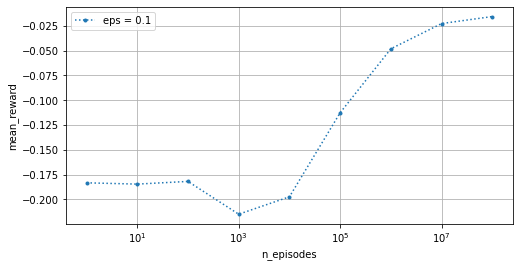

In [89]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.xlabel("n_episodes")
plt.ylabel("mean_reward")
plt.xscale("log")
env = BlackjackEnvDoubleCount()
for eps in [0.1]:
    all_n_episodes = np.array([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000], dtype=int)
    mean_rewards = get_score_train_plot(MCControlAgent, env, all_n_episodes=all_n_episodes, n_avg=int(1e6), eps=eps, n_action=3, n_space=(32, 11, 2, 41))
    plt.plot(all_n_episodes, mean_rewards, ".:", label = f"eps = {eps}")
    
plt.legend()

Стало еще лучше по сравнению с предыдущим пунктом. Средний выигрыш > -0.025. Однако казино все равно выигрывает. Возможно, применение off-policy алгоритмов и более тщательный подбор гиперпараметров нам бы помог обыграть казино. Тем не менее наш алгоритм работает и показывает адекватные результаты. На этом хотелось бы подытожить выполнение этого задания.